# Инициализация.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, Latex
from numba import njit, jit, prange
from scipy import integrate
from scipy import special
from tqdm import tqdm

sns.set_style("whitegrid")

# Загрузка и предпросмотр.

In [ ]:
def count_words_in_file(file_path):
    word_counts = []
    with open(file_path, 'r') as file:
        for line in file:
            words = line.split()
            word_counts.append(len(words))
    return word_counts


file_path = '/content/drive/MyDrive/corpus_hdd/russian_nofraglit_corpus.txt'
c = count_words_in_file(file_path)
x = np.asarray (c)
#x = x[x > 1000]

In [ ]:
##no need to run
dic_data = {'words_count':c}
pd_data = pd.DataFrame.from_dict(dic_data)
pd_data.to_csv('/content/drive/MyDrive/corpus_hdd/russian_nofraglit_corpus.csv', index=True)

In [ ]:
x_data = pd.read_csv('/content/drive/MyDrive/corpus_hdd/russian_nofraglit_corpus.csv')
x = x_data['words_count'].to_list()
x = [value for value in x if value!= 0] #we 6 empty files
x = np.asarray(x)
print(len(x))

6429


In [ ]:
fullBook=x

In [ ]:
x = x[x > 1000]

In [ ]:
x = x[x < 100000]

In [ ]:
len(x)

6429

In [ ]:
percentage_of_masterpieces = (len(x)*100)/len(fullBook)
print("The percentage of masterpieces between the two cutoff of the language: ", percentage_of_masterpieces, "%")

The percentage of masterpieces between the two cutoff of the language:  79.34359931560118 %


## Метод Хилла

In [ ]:
@njit(parallel=True)
def compute_hill_values(x):
    sorted_x = np.sort(x)[::-1]
    hill_values = np.zeros(sorted_x.size - 1)
    for k in prange(1, sorted_x.size):
        hill_values[k - 1] = np.sum(np.log(sorted_x[:k] / sorted_x[k])) / k
    return sorted_x, hill_values

In [ ]:
sorted_x, hill_values = compute_hill_values(x)
ks = np.arange(1, sorted_x.size)
#print(ks)
beta = np.median(hill_values) ** -1
#print(beta)
alpha = beta + 1
display(Latex(f'$\\alpha={alpha}$'))

<IPython.core.display.Latex object>

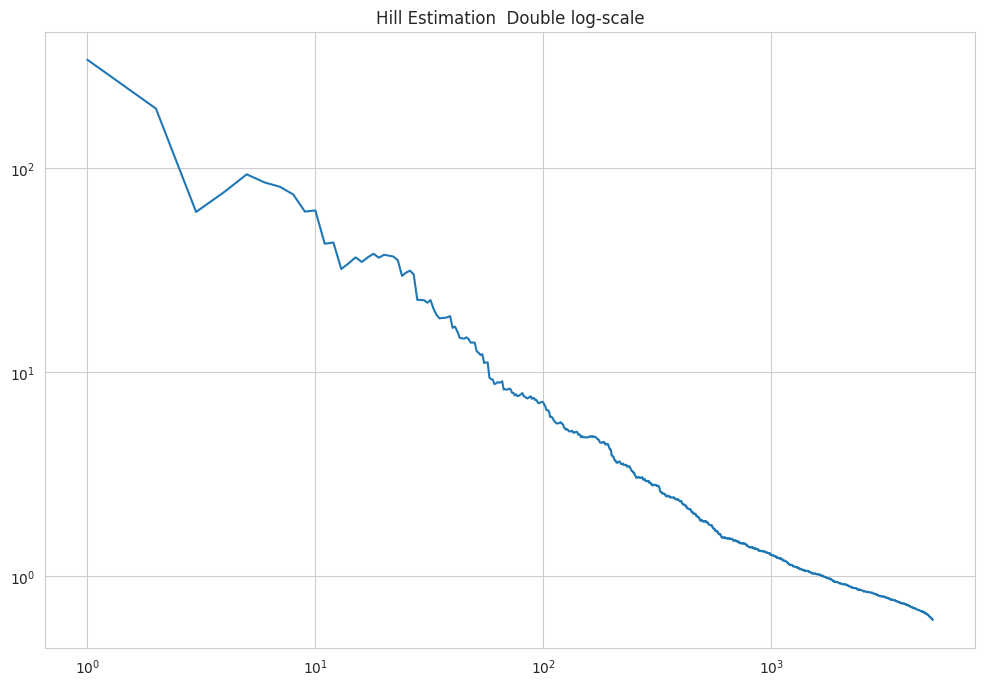

In [ ]:
Hill_wolframe = {}
plt.figure(figsize=(12, 8) )
plt.title("Hill Estimation  Double log-scale")
plt.plot(ks, hill_values ** -1)
plt.yscale('log')
plt.xscale('log')
plt.show()
Hill_wolframe["Ks"]=ks
Hill_wolframe["hill_value"]= hill_values ** -1

## Линейный биннинг

# Тест Pruessner

## Биннинг

In [ ]:
alpha

1.8419245490638656

In [ ]:
@njit
def get_exp_bins(selection, bins_count):
    R = (selection.max() / selection.min()) ** (1 / bins_count)
    c = selection.min() / R
    linspace = np.arange(bins_count) * ((bins_count) / (bins_count - 1)) + 1
    bins = c * R ** linspace
    return bins

In [ ]:
import random
random.seed(10)
def get_different_size_of_dataset(input_data, percentage):
  percent = (int) (percentage * len(input_data)/100)
  sample_data = random.sample(list(input_data), percent)
  return(np.array(sample_data))

##All Data

6
6429
5786
5143
4500
3857
3214


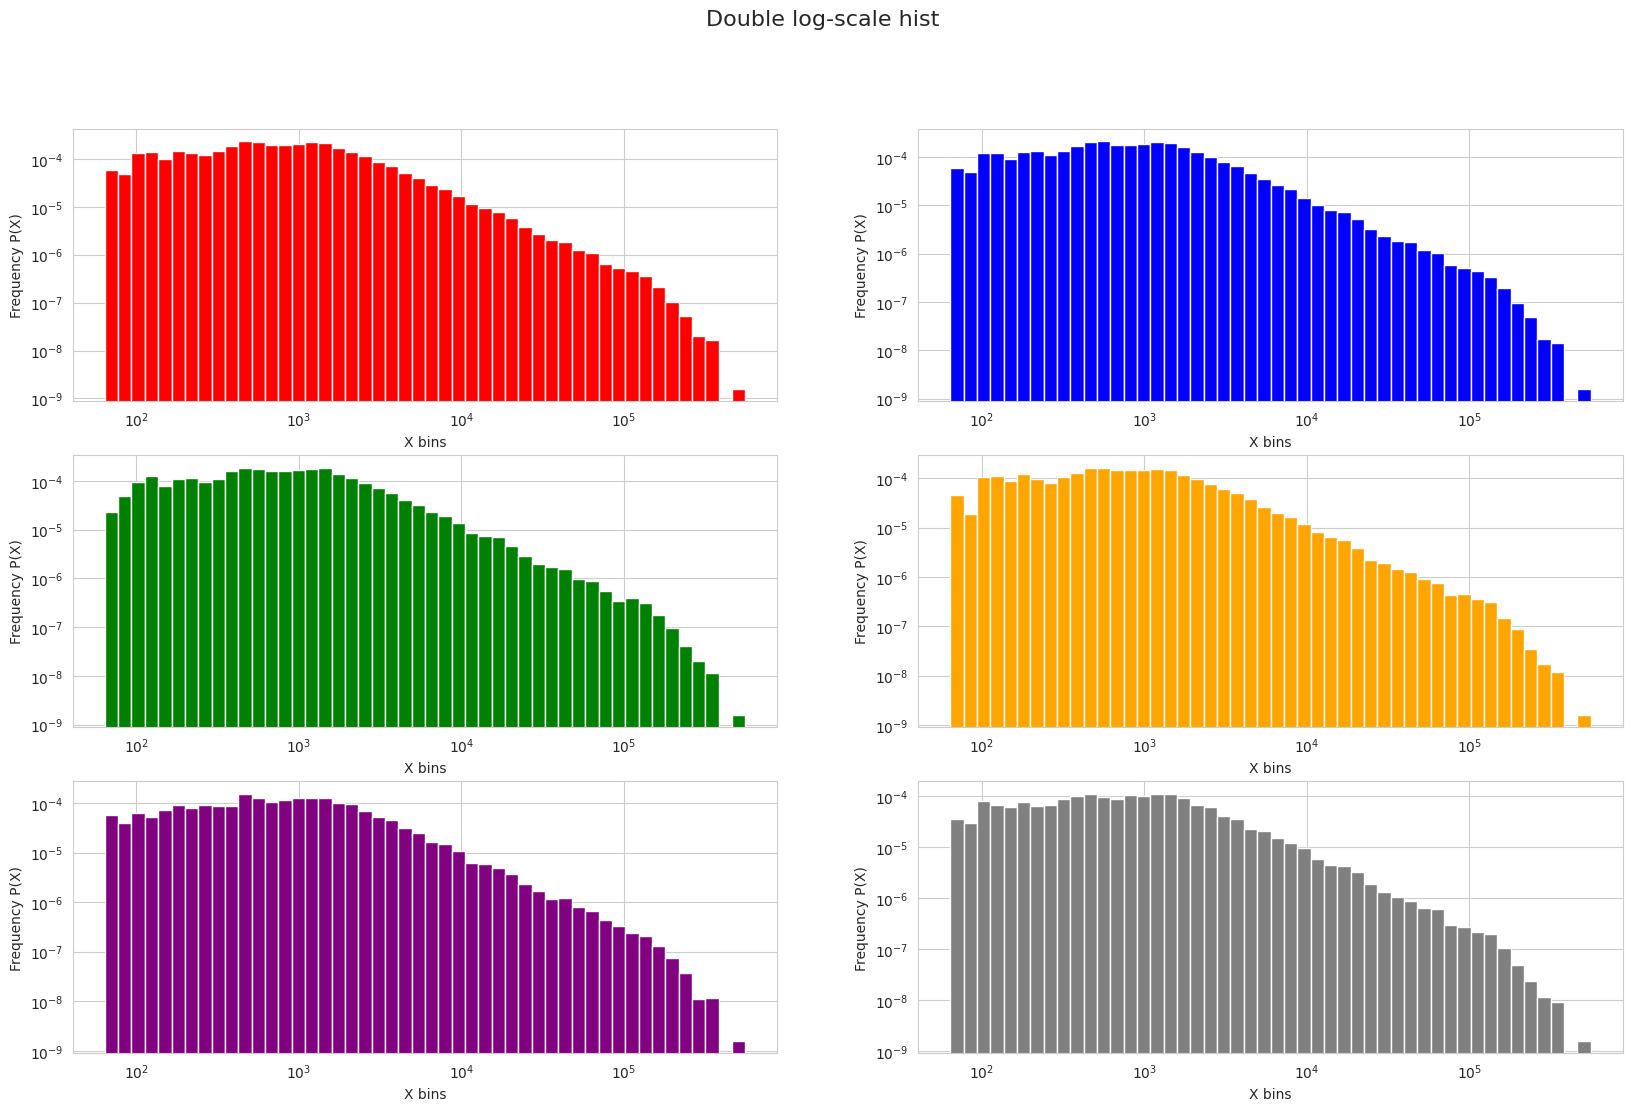

In [ ]:
percentage = [100,90, 80, 70, 60, 50]
all_samples_of_full_data = []
exp_bins_count = 50
x_exp_bins_all_data = []
#xticks = np.arange(x.min(),x.max()+100,1000)
k = 0
j = 0
print(len(percentage))
fig, axs = plt.subplots(3, 2, figsize=(20,12))#,sharex=True
fig.suptitle("Double log-scale hist", fontsize=16)
colors = ['red','blue','green','orange','purple','gray']
for i in range(len(percentage)):
  all_samples_of_full_data.append(get_different_size_of_dataset(fullBook,percentage[i]))
  print(len(all_samples_of_full_data[-1]))
  x_exp_bins_all_data.append(get_exp_bins(all_samples_of_full_data[-1], exp_bins_count))
  pdf = np.array([np.sum([(all_samples_of_full_data[-1] >= bin_start) & (all_samples_of_full_data[-1] < bin_end)]) for bin_start, bin_end in zip(x_exp_bins_all_data[-1][:-1], x_exp_bins_all_data[-1][1:])]) / x.shape[0]
  pdf_exp = pdf / (x_exp_bins_all_data[-1][1:] -x_exp_bins_all_data[-1][:-1])
  if i%2 == 0:
    axs[k,j].hist(x_exp_bins_all_data[-1][:-1], x_exp_bins_all_data[-1][1:], weights=pdf_exp, color=colors[i])
  else:
    j+=1

    axs[k,j].hist(x_exp_bins_all_data[-1][:-1], x_exp_bins_all_data[-1][1:], weights=pdf_exp, color=colors[i])
    k+=1
    j=0

for ax in axs.flat:
    ax.set(xlabel='X bins', ylabel='Frequency P(X)')
    ax.set(xscale= 'log', yscale = 'log')

<Figure size 1200x900 with 0 Axes>

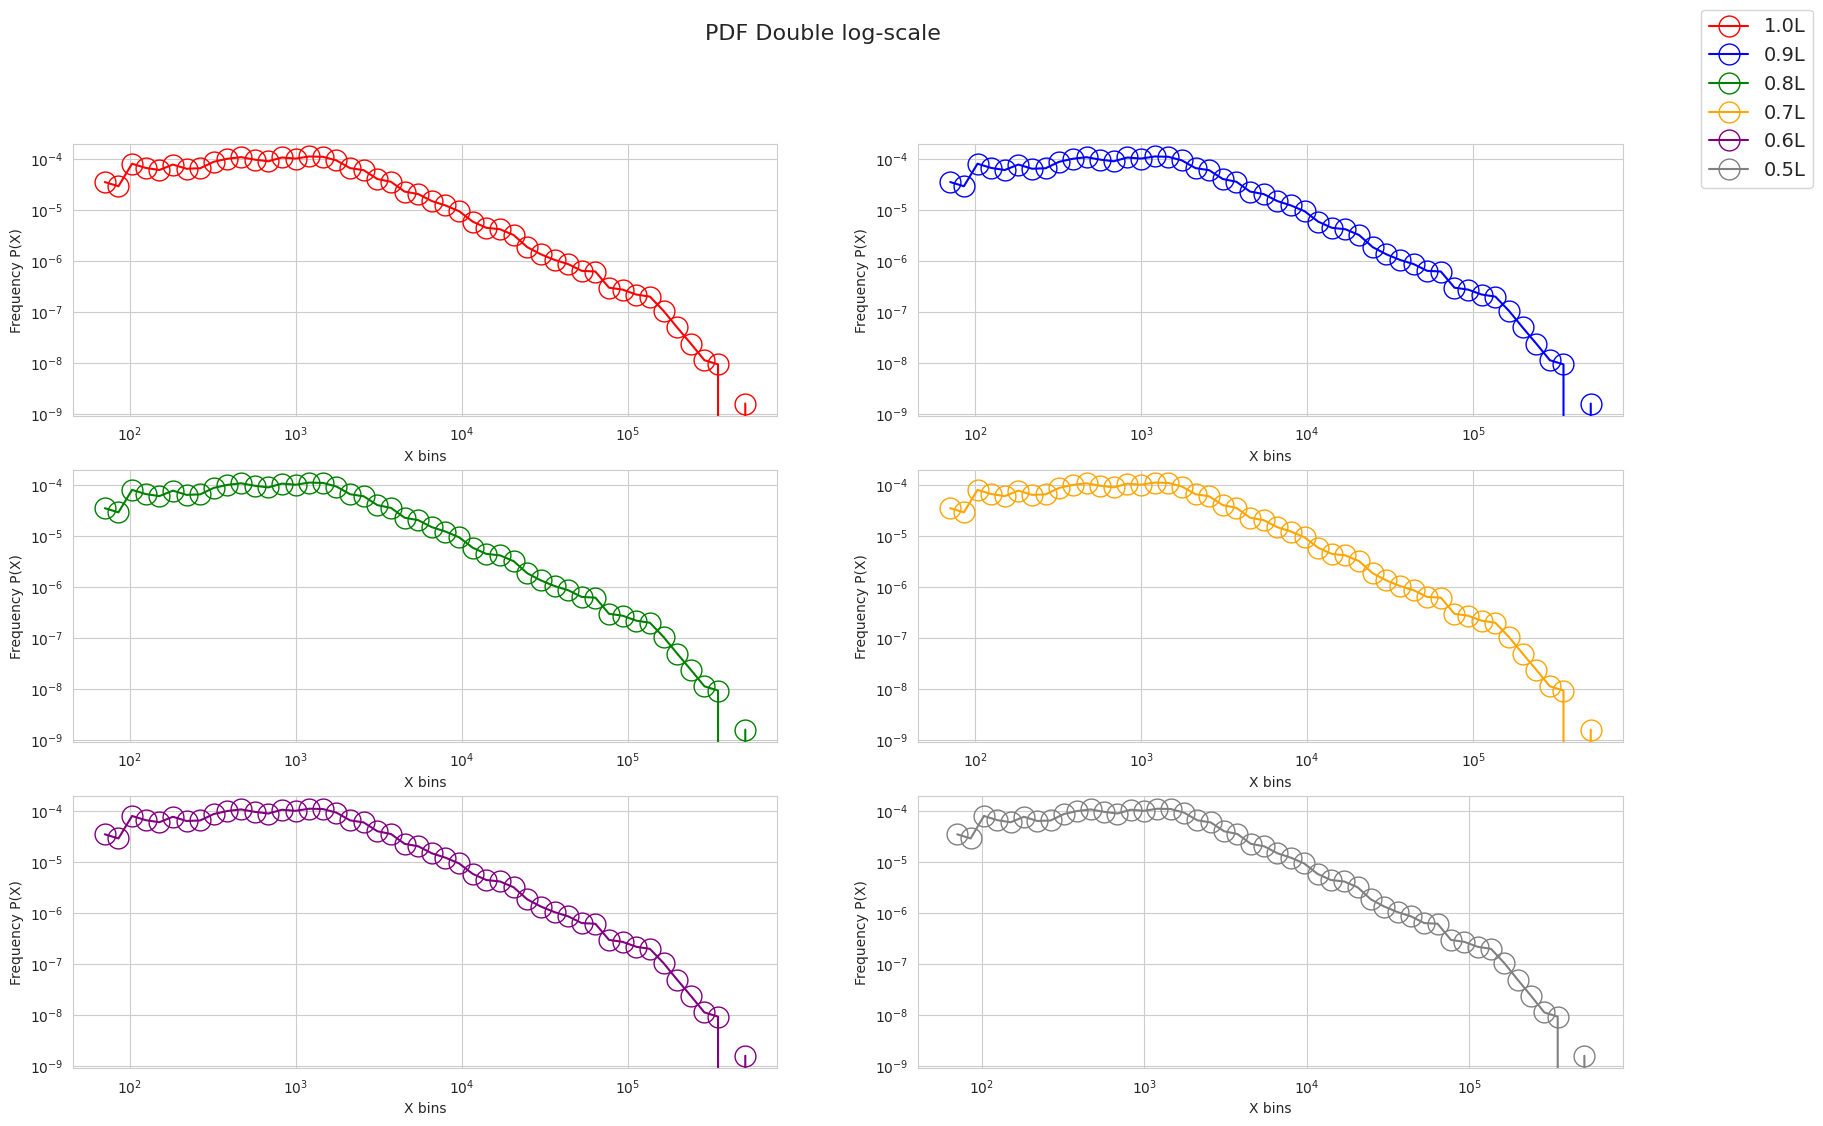

In [ ]:
figure = plt.gcf()
k = 0
j = 0
fig, axs = plt.subplots(3, 2, figsize=(20,12))
fig.suptitle("PDF Double log-scale", fontsize=16)

for i in range(len(all_samples_of_full_data)):
  n, bins, _ = plt.hist(x_exp_bins_all_data[i][:-1],x_exp_bins_all_data[i][1:], weights=pdf_exp, alpha=0.0)
  if i%2 == 0:
    axs[k,j].plot(bins[:-1] + 0.5 * (bins[1:] - bins[:-1]), n, marker="o", markersize=15, markerfacecolor="None", color = colors[i], label = str(percentage[i]/100) + "L")
  else:
    j+=1
    axs[k,j].plot(bins[:-1] + 0.5 * (bins[1:] - bins[:-1]), n, marker="o", markersize=15, markerfacecolor="None",color = colors[i], label = str(percentage[i]/100) + "L")
    k+=1
    j=0
lines= []
labels = []
for ax in axs.flat:
    ax.set(xlabel='X bins', ylabel='Frequency P(X)')
    ax.set(xscale='log', yscale='log')
    #ax.legend(loc = "upper right")
    size = figure.get_size_inches()
    figure.set_size_inches(size * (12.0 / size[0]))
    Line, Label = ax.get_legend_handles_labels()
    lines.extend(Line)
    labels.extend(Label)

fig.legend(lines, labels, loc = "upper right", fontsize = 14)
plt.show()

##The Data Between Two Cutoff

6
5101
4590
4080
3570
3060
2550


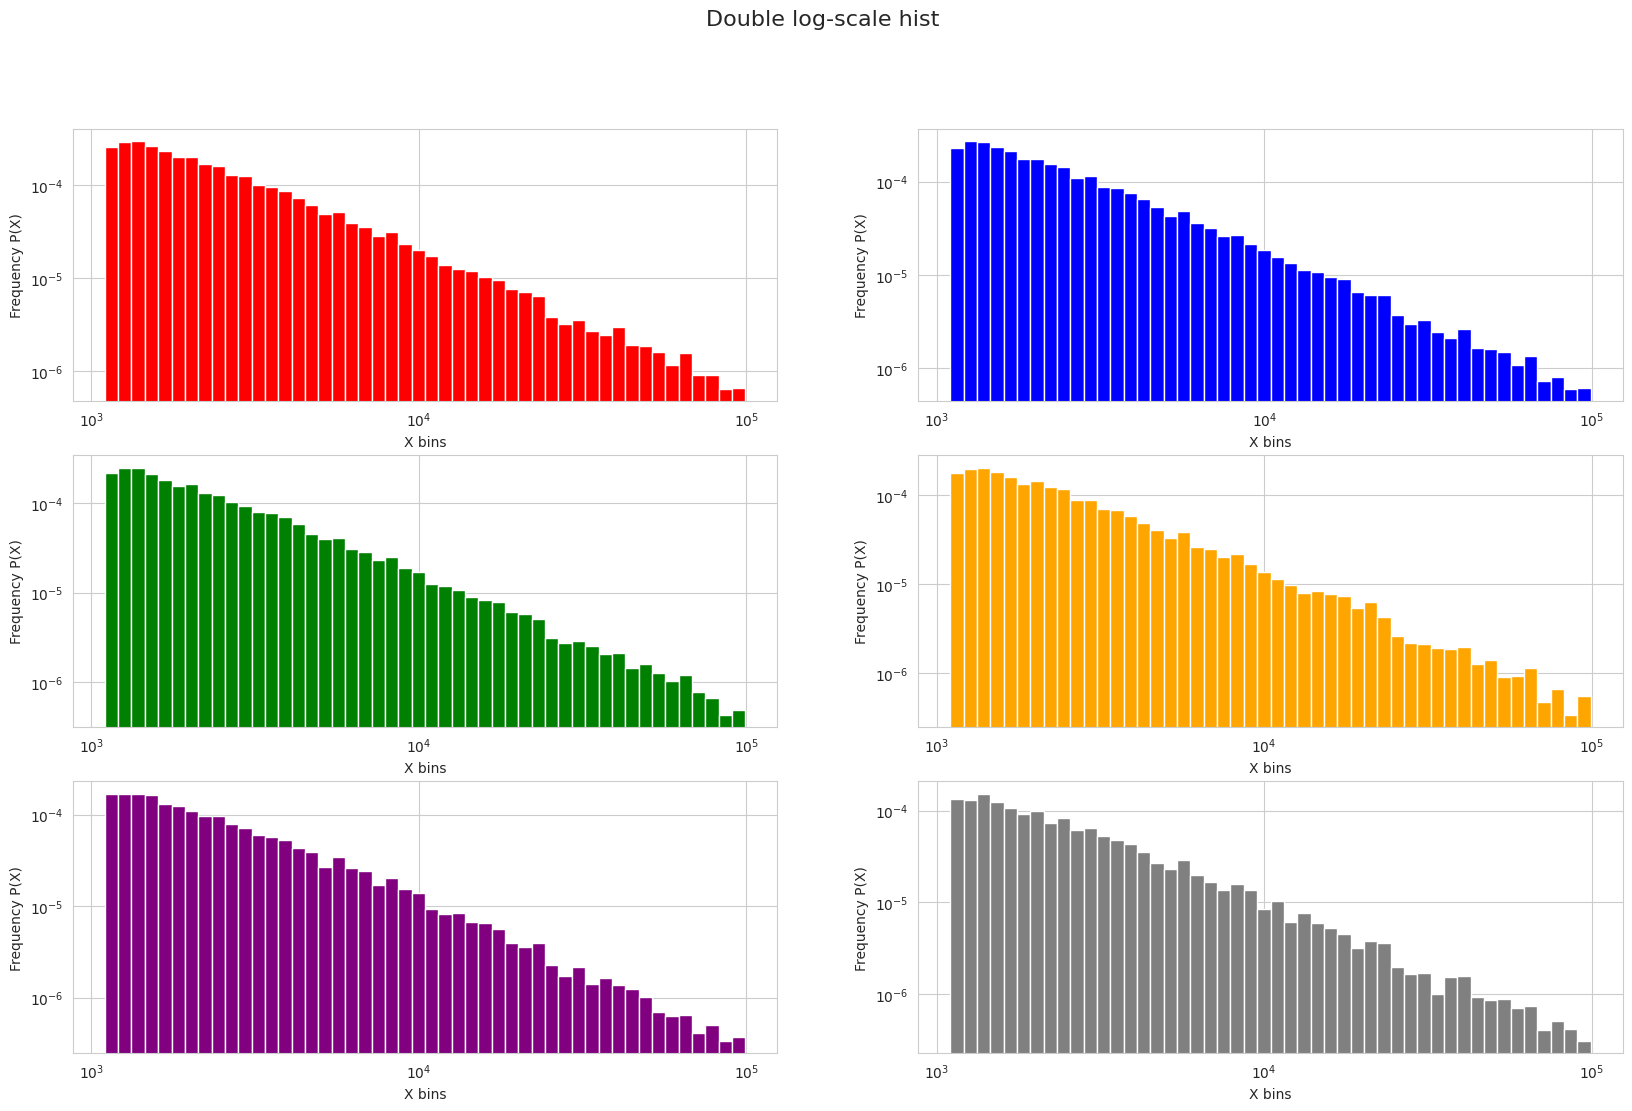

In [ ]:
percentage = [100,90, 80, 70, 60, 50]
all_samples_of_data = []
exp_bins_count = 50
x_exp_bins_all = []

k = 0
j = 0
print(len(percentage))
fig, axs = plt.subplots(3, 2, figsize=(20,12))#,sharex=True
fig.suptitle("Double log-scale hist", fontsize=16)
colors = ['red','blue','green','orange','purple','gray']
for i in range(len(percentage)):
  all_samples_of_data.append(get_different_size_of_dataset(x,percentage[i]))
  print(len(all_samples_of_data[-1]))
  x_exp_bins_all.append(get_exp_bins(all_samples_of_data[-1], exp_bins_count))
  pdf = np.array([np.sum([(all_samples_of_data[-1] >= bin_start) & (all_samples_of_data[-1] < bin_end)]) for bin_start, bin_end in zip(x_exp_bins_all[-1][:-1], x_exp_bins_all[-1][1:])]) / x.shape[0]
  pdf_exp = pdf / (x_exp_bins_all[-1][1:] - x_exp_bins_all[-1][:-1])
  if i%2 == 0:
    axs[k,j].hist(x_exp_bins_all[-1][:-1], x_exp_bins_all[-1][1:], weights=pdf_exp, color=colors[i])
  else:
    j+=1

    axs[k,j].hist(x_exp_bins_all[-1][:-1], x_exp_bins_all[-1][1:], weights=pdf_exp, color=colors[i])
    k+=1
    j=0

for ax in axs.flat:
    ax.set(xlabel='X bins', ylabel='Frequency P(X)')
    ax.set(xscale= 'log', yscale = 'log')

<Figure size 1200x900 with 0 Axes>

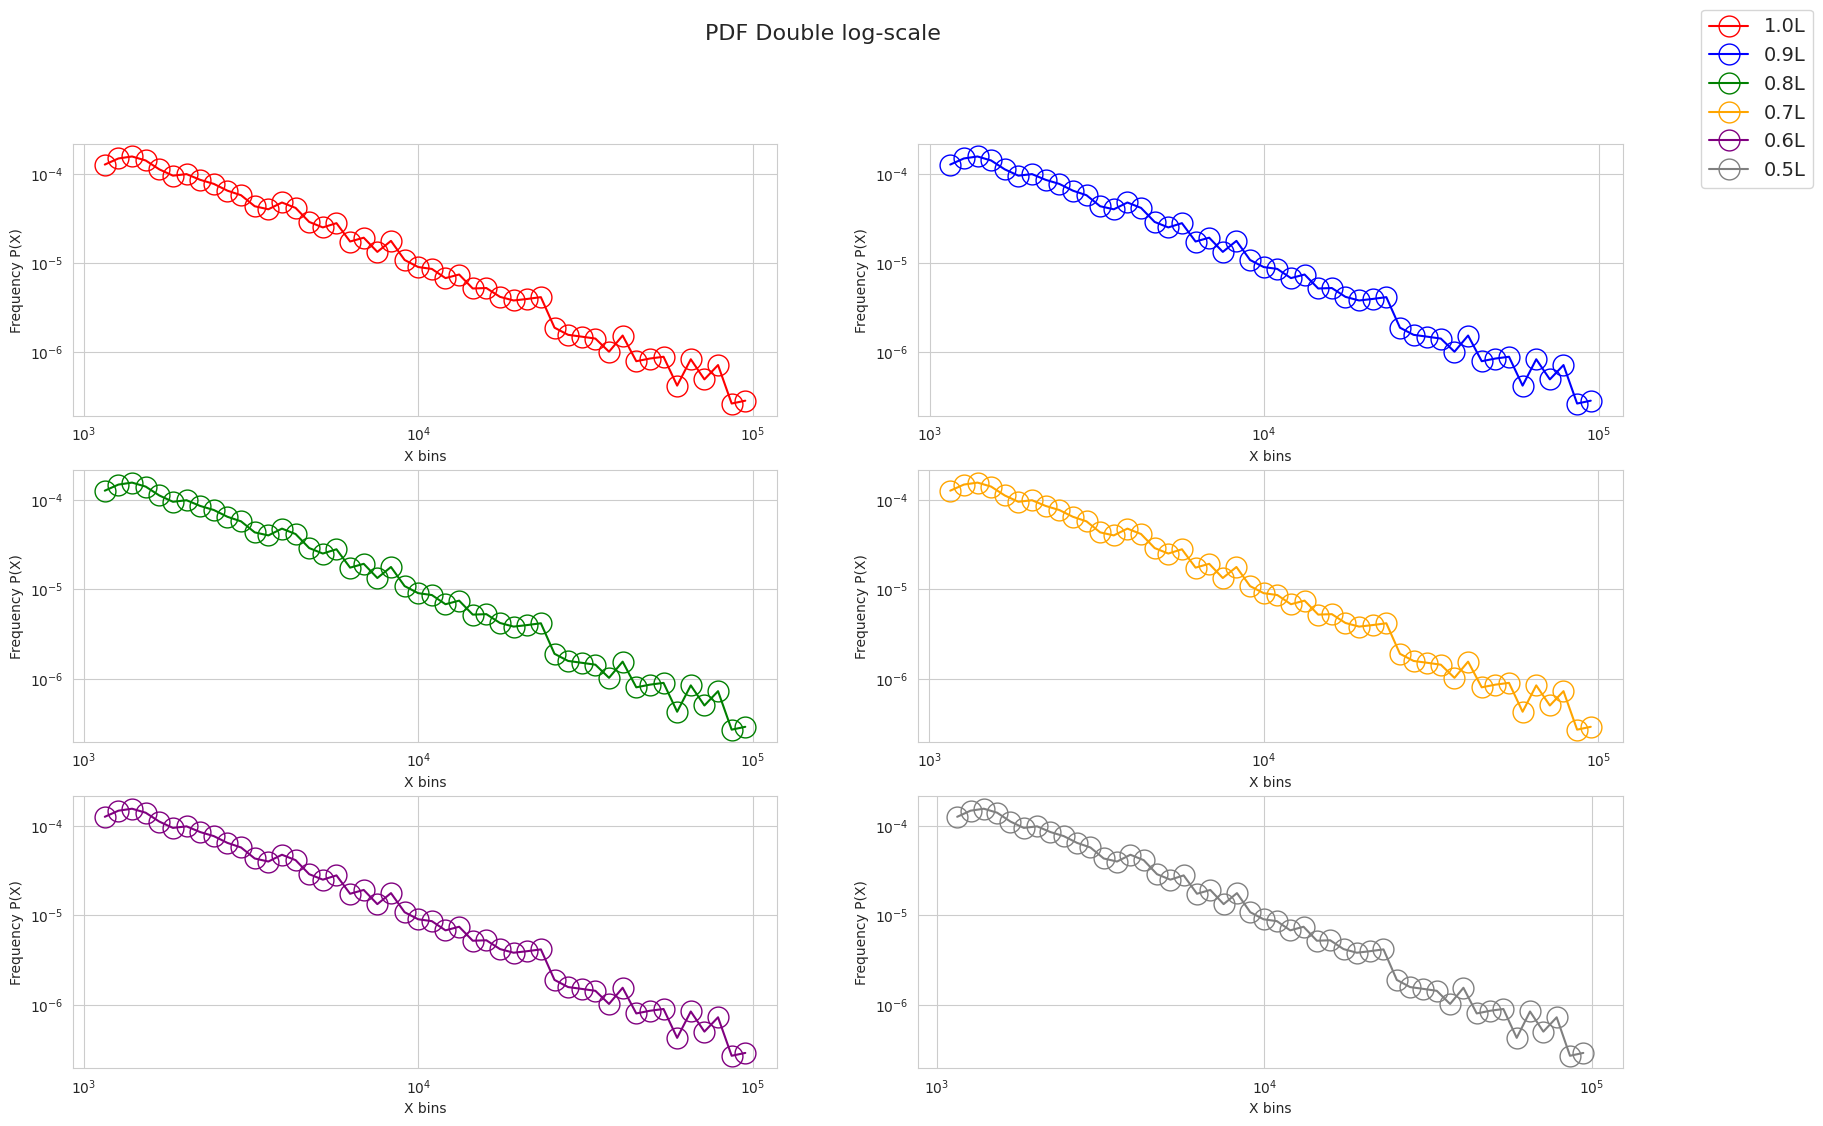

In [ ]:
figure = plt.gcf()
k = 0
j = 0
fig, axs = plt.subplots(3, 2, figsize=(20,12))
fig.suptitle("PDF Double log-scale", fontsize=16)

for i in range(len(all_samples_of_data)):
  n, bins, _ = plt.hist(x_exp_bins_all[i][:-1],x_exp_bins_all[i][1:], weights=pdf_exp, alpha=0.0)
  if i%2 == 0:
    axs[k,j].plot(bins[:-1] + 0.5 * (bins[1:] - bins[:-1]), n, marker="o", markersize=15, markerfacecolor="None", color = colors[i], label = str(percentage[i]/100) + "L")
  else:
    j+=1
    axs[k,j].plot(bins[:-1] + 0.5 * (bins[1:] - bins[:-1]), n, marker="o", markersize=15, markerfacecolor="None",color = colors[i], label = str(percentage[i]/100) + "L")
    k+=1
    j=0
lines= []
labels = []
for ax in axs.flat:
    ax.set(xlabel='X bins', ylabel='Frequency P(X)')
    ax.set(xscale='log', yscale='log')
    #ax.legend(loc = "upper right")
    size = figure.get_size_inches()
    figure.set_size_inches(size * (12.0 / size[0]))
    Line, Label = ax.get_legend_handles_labels()
    lines.extend(Line)
    labels.extend(Label)

fig.legend(lines, labels, loc = "upper right", fontsize = 14)
plt.show()

## Нелинейное преобразование координат.

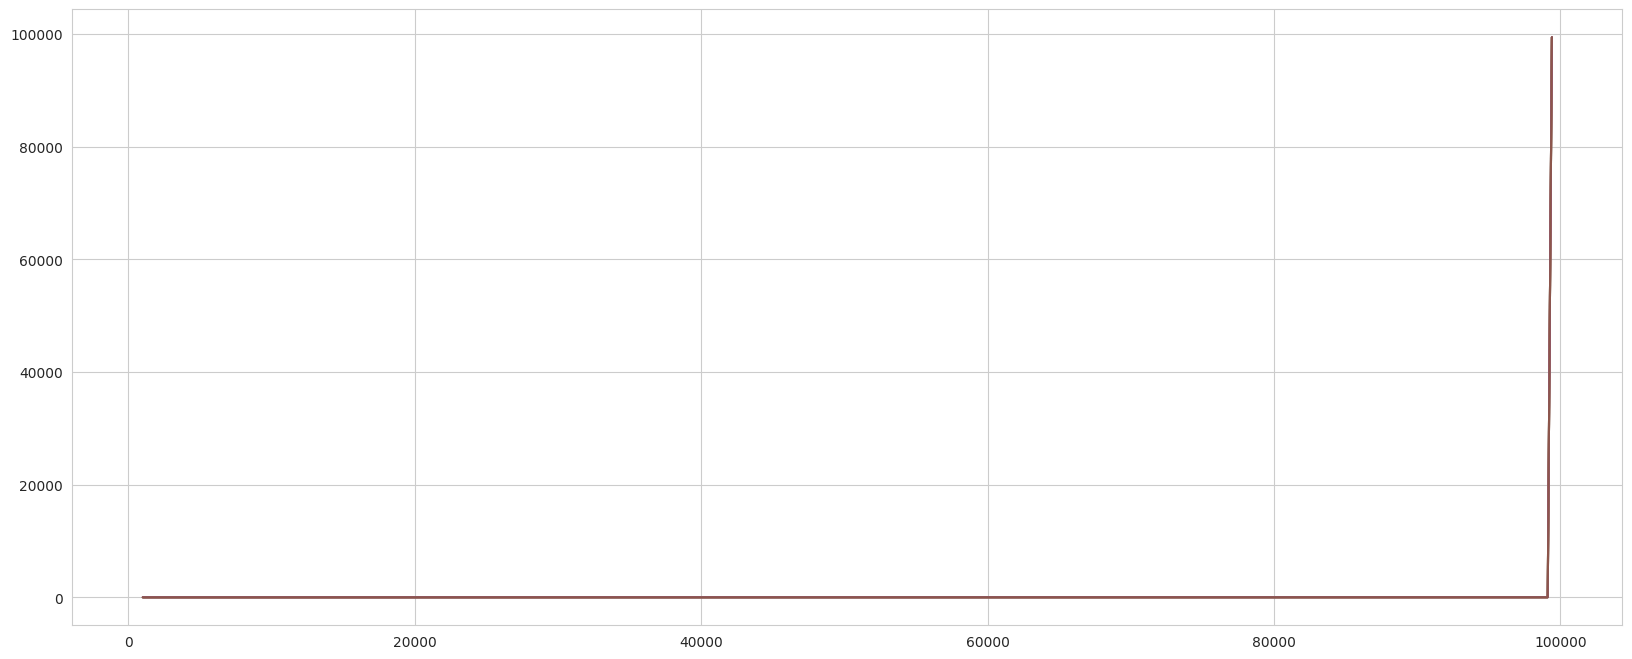

In [ ]:
Prussner_wolframe = []
new_data = {}
alpha = 1.55
plt.figure(figsize=(20, 8))
for i in range(len(all_samples_of_data)):
  new_pdf = all_samples_of_data[i].copy()
  for index, (bin_start, bin_end) in enumerate(zip(x_exp_bins_all[i][:-1], x_exp_bins_all[i][1:])):
    new_pdf[(all_samples_of_data[i] >= bin_start) & (all_samples_of_data[i] < bin_end)]=new_pdf[(all_samples_of_data[i] >= bin_start) & (all_samples_of_data[i] < bin_end)] ** alpha
    new_pdf[(all_samples_of_data[i]>= bin_start) & (all_samples_of_data[i] < bin_end)]=new_pdf[(all_samples_of_data[i] >= bin_start) & (all_samples_of_data[i] < bin_end)] * pdf_exp[index]


  sorted_idxs = np.argsort(all_samples_of_data[i])
  plt.plot(all_samples_of_data[i][sorted_idxs], new_pdf[sorted_idxs])

  new_data["x"+str(percentage[i])]= all_samples_of_data[i][sorted_idxs]
  new_data["y"+str(percentage[i])]= new_pdf[sorted_idxs]
  Prussner_wolframe.append(new_data)
  new_data = {}


plt.savefig('result.pdf')

plt.show()

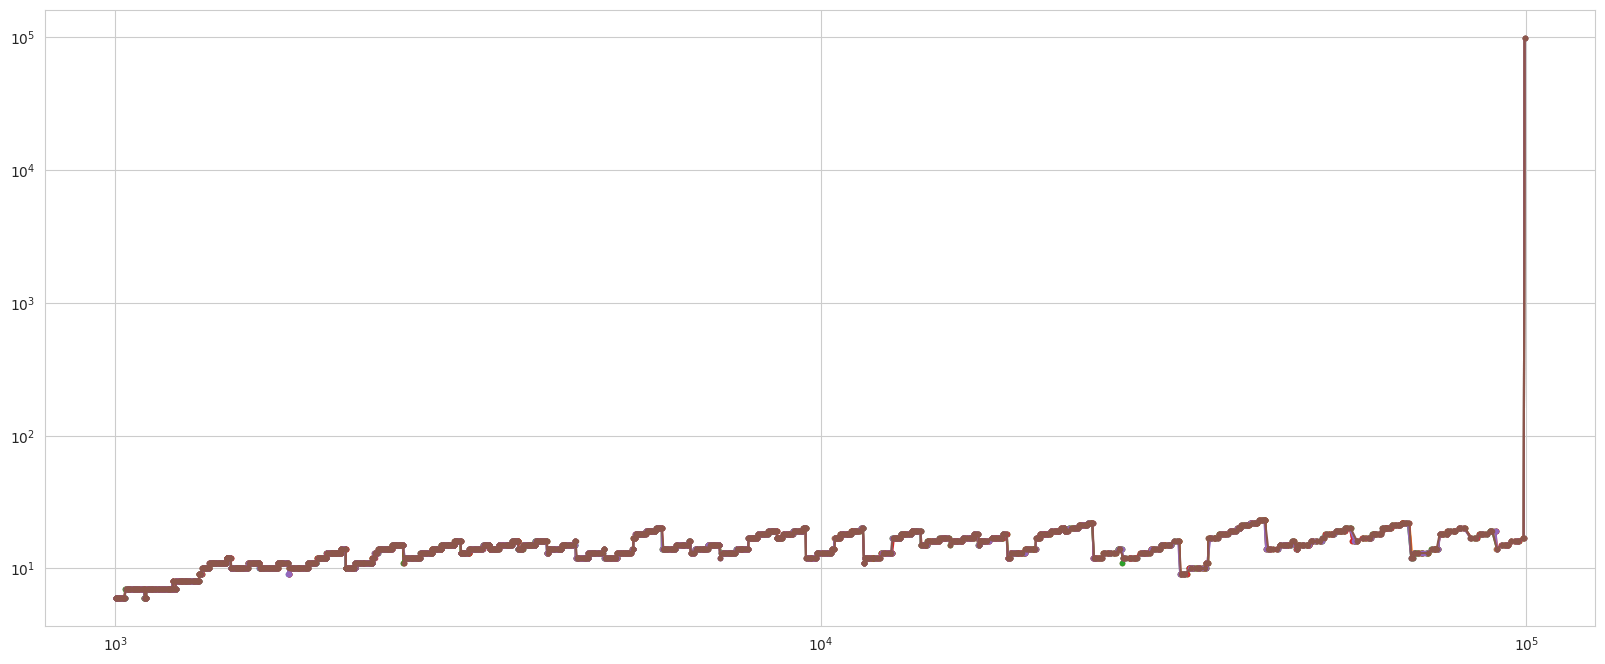

In [ ]:
alpha=1.55
plt.figure(figsize=(20, 8))
for i in range(len(all_samples_of_data)):
  new_pdf = all_samples_of_data[i].copy()
  for index, (bin_start, bin_end) in enumerate(zip(x_exp_bins_all[i][:-1], x_exp_bins_all[i][1:])):
    new_pdf[(all_samples_of_data[i] >= bin_start) & (all_samples_of_data[i] < bin_end)]=new_pdf[(all_samples_of_data[i] >= bin_start) & (all_samples_of_data[i] < bin_end)] ** alpha
    new_pdf[(all_samples_of_data[i]>= bin_start) & (all_samples_of_data[i] < bin_end)]=new_pdf[(all_samples_of_data[i] >= bin_start) & (all_samples_of_data[i] < bin_end)] * pdf_exp[index]

    sorted_idxs = np.argsort(all_samples_of_data[i])
  plt.plot(all_samples_of_data[i][sorted_idxs], new_pdf[sorted_idxs], marker='o', markersize=3)
plt.yscale('log')
plt.xscale('log')
#plt.savefig('/content/drive/MyDrive/plt_graphs/russian.pdf')

plt.show()

In [ ]:
xmin=min(all_samples_of_data[0])
xmin

1001

In [ ]:
#Convert all dictionaries into dataframe then into CSV file, please just update the name of languages
import pandas as pd
def convert_into_pd_csv(data, name):
  new_pd = pd.DataFrame.from_dict(data)
  new_pd.to_csv('/content/drive/MyDrive/power-law-test/Walfram_grafics/russian/russian_'+name +'.csv', header=None,index=False) ## just updte the name of language based on each language here Arabic_ for English write English_
'''
convert_into_pd_csv(Histogram_wolframe, 'Histogram_wolframe')
print("done!1")
convert_into_pd_csv(Histogram_dot_wolframe, 'Histogram_dot_wolframe')
print("done!2")
convert_into_pd_csv(Histogram_cutoff_wolframe, 'Histogram_cutoff_wolframe')
print("done!3")
convert_into_pd_csv(Histogram_dot_cutoff_wolframe, 'Histogram_dot_cutoff_wolframe')
print("done!4")
'''
for i in range(len(percentage)):
  convert_into_pd_csv(Prussner_wolframe[i], 'Prussner_wolframe'+str(percentage[i]))
print("done!5")
convert_into_pd_csv(Hill_wolframe, 'Hill_wolframe')
print("done!6")

done!5
done!6


# Тест Clauset

## Оценка параметра $x_{min}$.

Предполагаем, что данные распределены непрерывно по степенному закону:

> $p(x)dx = Pr(x \leq X \leq x + dx) =  \frac{\alpha-1}{x_{min}}\cdot\left(\frac{x}{x_{min}}\right)^{-\alpha}dx$

Для того, чтобы оценить $x_{min}$ воспользуемся следующим критерием: подберём такую степенную модель $M(\hat{\alpha}, \hat{x}_{min})$, для которой $D_{KS}=\underset{x\geq \hat{x}_{min}}{max}\left|\overline{CDF}(x)-CDF_{M}(x)\right|$ минимально. Тогда $\hat{x}_{min}$ и будет нашим оценочным значением.

In [ ]:
@njit
def m_density_func(x, alpha, x_min):
    return ((alpha - 1) / x_min) * (x / x_min) ** (-alpha)

@njit
def m_cdf(x, alpha, x_min):
    return (x / x_min) ** (1 - alpha)

In [ ]:
@njit
def fast_ks_test(x, exp_bins_count, x_min):
    x_filtered = x[x >= x_min]

    if x_filtered.shape[0] < exp_bins_count:
        exp_bins_count = x_filtered.shape[0]
    if exp_bins_count < 2:
        return np.inf, np.nan, np.empty(1), np.empty(1)

    exp_bins = get_exp_bins(x_filtered, exp_bins_count)
    exp_bins_counts = np.zeros(exp_bins.shape[0] - 1)
    for index, exp_bin in enumerate(exp_bins[:-1]):
        exp_bins_counts[index] = np.sum(x_filtered >= exp_bin)
    bins_cdf = exp_bins_counts / x_filtered.shape[0]

    estimated_alpha = 1 + x_filtered.shape[0] * (np.sum(np.log(x_filtered / x_min)) ** (-1))

    m_bins_cdf = m_cdf(exp_bins[:-1], estimated_alpha, x_min)

    ks_distance = np.max(np.abs(bins_cdf - m_bins_cdf) / np.sqrt(m_bins_cdf * (1 - m_bins_cdf)))

    return ks_distance, estimated_alpha, bins_cdf, m_bins_cdf

Подберём оптимальное значение по сетке. Среди одних и тех же значений x_min выбираем минимальное расстояние Колмогорова-Смирнова, получаем соответствие между каждым уникальным x_min и его расстоянием. Находим самый левый локальный минимум с глубиной, большей или равной заданной.

In [ ]:
@njit
def find_left_min(values, min_depth):
    left_ptr = 0
    right_ptr = 0

    if values.size == 1:
        return 0

    while right_ptr != (values.size - 1) and values[right_ptr] < values[right_ptr + 1]:
        right_ptr += 1
    if right_ptr == (values.size - 1):
        return 0

    left_ptr = right_ptr

    while right_ptr < (values.size - 1):
        if values[right_ptr] >= values[right_ptr + 1]:
            right_ptr += 1

        else:
            left_depth = values[left_ptr] - values[right_ptr]
            if left_depth < min_depth:
                right_ptr += 1
                continue
            left_ptr = right_ptr
            while right_ptr < (values.size - 1):
                if values[right_ptr] < values[left_ptr]:
                    left_ptr = right_ptr
                if values[right_ptr] < values[right_ptr + 1]:
                    right_ptr += 1
                else:
                    right_depth = values[right_ptr] - values[left_ptr]
                    if right_depth < min_depth:
                        right_ptr += 1
                        continue
                    else:
                        break

            if right_ptr == (values.size - 1):
                right_depth = values[right_ptr] - values[left_ptr]
            if min(left_depth, right_depth) >= min_depth:
                return left_ptr
            else:
                left_ptr = right_ptr

    return -1

In [ ]:
from collections import defaultdict

MIN_X_MIN = 0 + 1e-8
xs_min_counts = 1000
xs_min = get_exp_bins(np.array([MIN_X_MIN, x.max()]), xs_min_counts)
# xs_min = np.logspace(np.log10(MIN_X_MIN), np.log10(x.max()), num=xs_min_counts)
# xs_min = np.linspace(MIN_X_MIN, x.max(), num=xs_min_counts)

best_x_min = None
best_bins_cdfs = None

ks_history = defaultdict(lambda: np.inf)
alphas_history = np.zeros(xs_min_counts)
bins_cdfs_history = dict()

min_ks_distance = np.inf
for index, x_min in tqdm(enumerate(xs_min), "Searching x_min", xs_min_counts):
    ks_distance, estimated_alpha, *bins_cdfs = fast_ks_test(x, exp_bins_count, x_min)
    ks_history[x_min] = ks_distance
    alphas_history[index] = estimated_alpha
    bins_cdfs_history[x_min] = bins_cdfs

Searching x_min: 100%|██████████| 1000/1000 [00:02<00:00, 419.46it/s]


In [ ]:
min_depth = 0.00000009
history_values = np.array(list(ks_history.values()))

min_ptr = find_left_min(history_values, min_depth)
while min_ptr == -1 or np.abs(history_values[min_ptr]) < 1e-8:
    min_depth -= 1e-2
    if min_depth <= 0:
        break
    min_ptr = find_left_min(history_values, min_depth)

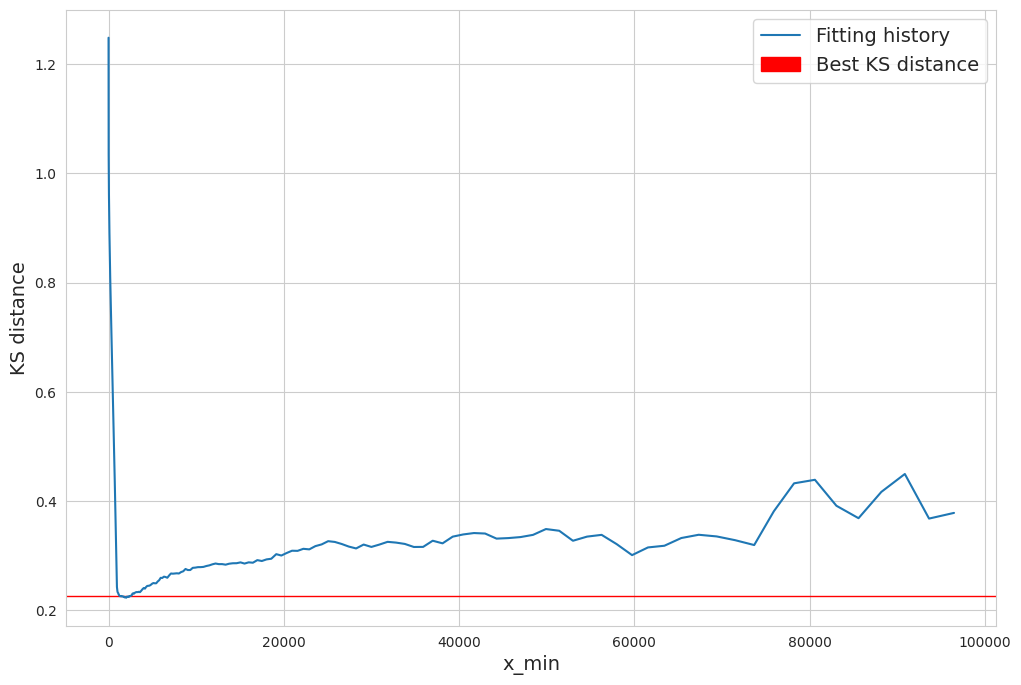

done!


In [ ]:
kolmogorov_wolframe = {}
min_ks_distance = history_values[min_ptr]

plt.figure(figsize=(12, 8))

plt.plot(list(ks_history.keys()), list(ks_history.values()), label="Fitting history")
plt.xlabel('x_min', fontsize=14)
plt.ylabel('KS distance', fontsize=14)

plt.axhspan(min_ks_distance, min_ks_distance + 1e-4, color='red', label="Best KS distance")
kolmogorov_wolframe["x"]=list(ks_history.keys())
kolmogorov_wolframe["y"]=list(ks_history.values())
kolmogorov_wolframe["z"] = min_ks_distance
plt.legend(fontsize=14)
plt.show()

convert_into_pd_csv(kolmogorov_wolframe,"kolmogorov_wolframe")
print("done!")

In [ ]:
best_x_min = list(ks_history.keys())[min_ptr]
best_bins_cdfs = bins_cdfs_history[best_x_min]

In [ ]:
display(Latex(f'$x_{"{min}"}=\hat{"{x}"}_{"{min}"}={best_x_min}$'))
display(Latex(f'$min(D_{"{KS}"})={min_ks_distance}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

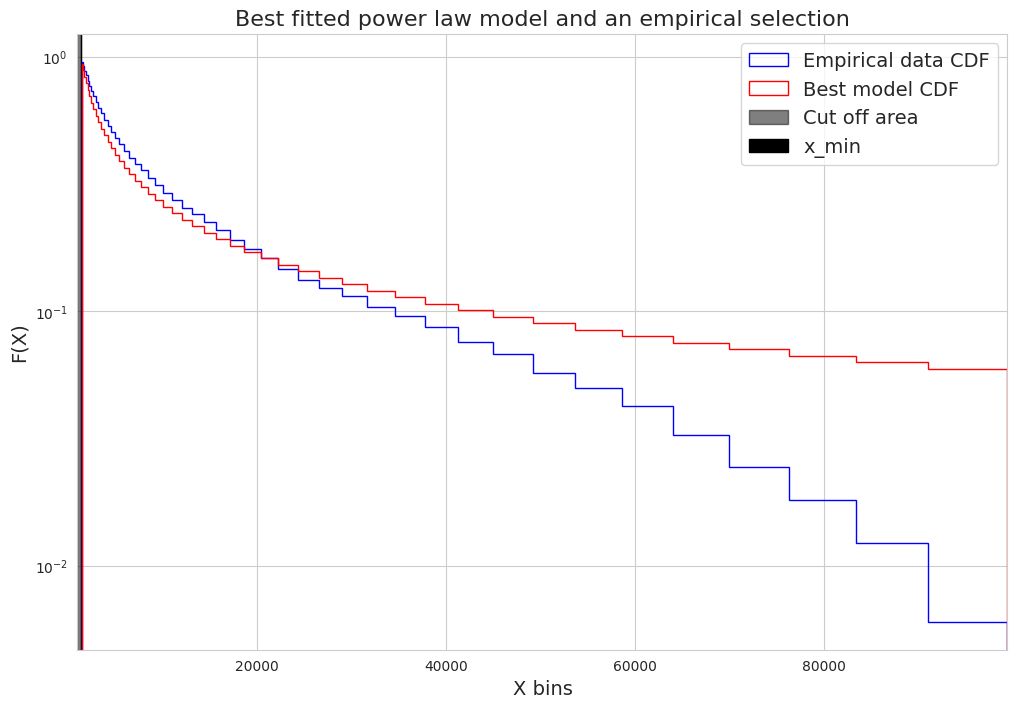

In [ ]:
plt.figure(figsize=(12, 8))

bins_cdf = best_bins_cdfs[0]
m_bins_cdf = best_bins_cdfs[1]

x_filtered = x[x >= best_x_min]
if x_filtered.shape[0] < exp_bins_count:
        exp_bins_count = x_filtered.shape[0]
exp_bins = get_exp_bins(x_filtered, exp_bins_count)

bins_starts = exp_bins[:-1]
bins_ends = exp_bins[1:]

plt.hist(bins_starts, bins_ends, weights=bins_cdf, color='blue',
         histtype = 'step', label='Empirical data CDF')
plt.hist(bins_starts, bins_ends, weights=m_bins_cdf, color='red',
         histtype = 'step', label='Best model CDF')

plt.xlabel('X bins', fontsize=14)
plt.ylabel('F(X)', fontsize=14)
plt.title("Best fitted power law model and an empirical selection", fontsize=16)

plt.axvspan(x.min(), best_x_min, 0, 1, alpha=0.5, color='black', label='Cut off area')
plt.axvspan(best_x_min, best_x_min + 1e-2, 0, 1, color='black', label='x_min')

plt.xlim(x.min(), x.max())

plt.yscale('log')
plt.legend(fontsize=14)
plt.show()

## Оценка параметра $\alpha$.

На данном этапе считаем, что $x_{min}$ нам известен.

In [ ]:
x_min = best_x_min

In [ ]:
x_min

1330.2182465013202

Оценка параметра $\alpha$ производится с помощью метода максимального правдоподобия. В данном случае MLE модель может быть записана в виде:

> $\hat{\alpha}=1 + n\left[\underset{i=1}{\overset{n}{\sum}}ln\frac{x_i}{x_{min}}\right]^{-1}$,

где $x_i, i=1,\cdots, n$ - наблюдаемые значения переменной x такие, что $x_i \geq x_{min}$; $\hat{\alpha}$ - спрогнозированное значение $\alpha$.

In [ ]:
filtered_x = x[x >= x_min]
n = filtered_x.shape[0]

alpha = 1 + n * (np.sum(np.log(filtered_x / x_min)) ** (-1))

In [ ]:
display(Latex(f'$\\alpha={alpha}$'))

<IPython.core.display.Latex object>

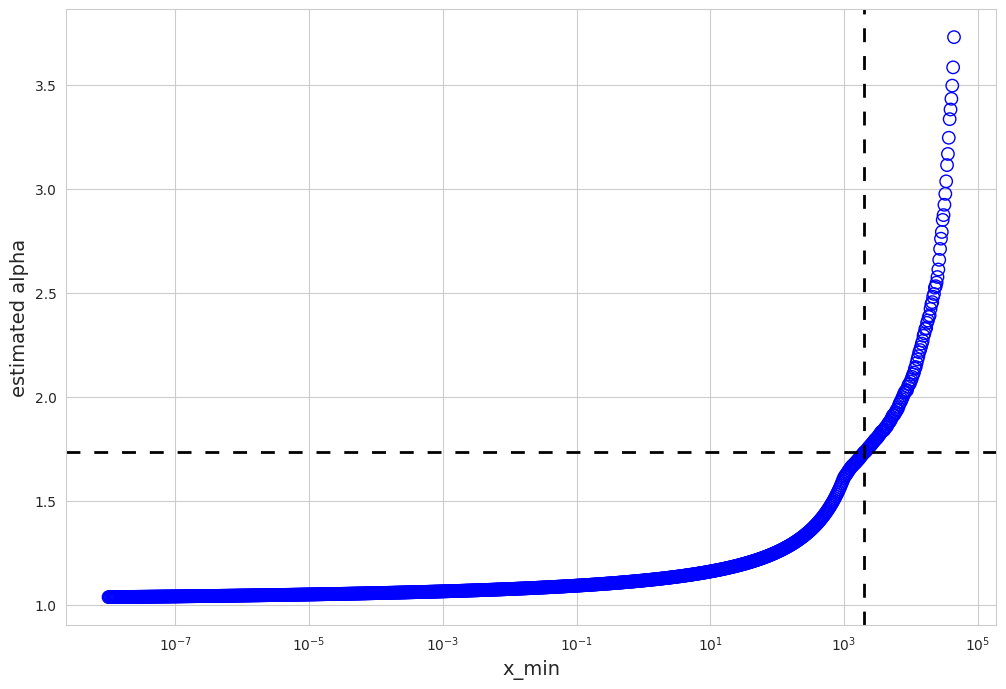

In [ ]:
plt.figure(figsize=(12, 8))

index_filter = (alphas_history >= alpha - 1.2) & (alphas_history < alpha + 2)
plt.scatter(xs_min[index_filter], alphas_history[index_filter], s=80, facecolors='none', edgecolors='b')

plt.axvline(best_x_min, linestyle='--', color='black', dashes=(5, 5), linewidth=2)
plt.axhline(alpha, linestyle='--', color='black', dashes=(5, 5), linewidth=2)

plt.xlabel('x_min', fontsize=14)
plt.xscale('log')
plt.ylabel('estimated alpha', fontsize=14)
plt.show()

## Тестирование на принадлежность выборки к степенному распределению.

Для вычисления $p$-статистики нам понадобится сгенерировать некоторое количество новых выборок данных из степенного распределения с параметрами ($\hat{\alpha}$, $\hat{x}_{min}$). Количество новых синтетических датасетов зависит от точности $ϵ$: если мы хотим, чтобы наша $p$-статистика имела ошибку не более $ϵ$, то необходимо сгенерировать $N \geq \frac{1}{4}ϵ^{-2}$ наборов данных.

In [ ]:
eps = 1e-2 # Выбор параметра epsilon.

synth_n = round(0.25 * (eps ** (-2)))
display(Latex(f'$\\epsilon={eps}\Rightarrow N={synth_n}$'))

<IPython.core.display.Latex object>

Генерируем датасеты так, чтобы та же часть набора данных, что и в эмпирической выборке $x\geq \hat{x}_{min}$, была распределена по степенному закону ($\hat{\alpha}$, $\hat{x}_{min}$), а остальная часть $x<\hat{x}_{min}$ была представлена выбранными равномерно случайными данными из соответствующей части базовой выборки.

In [ ]:
@njit
def power_law_generate(alpha, x_min, probability):
    # Так как x_min > 0, функция плотности ax^b монотонна => можно построить
    # биективное отображение из значений F(x) в x.
    return (x_min ** (1 - alpha) * probability) ** (1 / (1 - alpha))

@njit
def generate_dataset(alpha, x_min, x, number_of_samples):
    n_tail = np.sum(x >= x_min)
    n_empirical = number_of_samples - n_tail

    power_law_probs = np.random.uniform(0, 1, number_of_samples)
    power_law_generated = power_law_generate(alpha, x_min, power_law_probs)

    if n_empirical != 0:
        random_values = np.random.uniform(0, 1, number_of_samples)
        random_samples = np.random.choice(x[x < x_min], number_of_samples)
        return np.where(random_values >= n_empirical / number_of_samples,
                        power_law_generated, random_samples)
    else:
        return power_law_generated

Вычислим $p$-статистику: (крайне времязатратный шаг)

In [ ]:
@njit(parallel=True)
def compute_p_value(alpha, x_min, x, synth_n, empirical_ks, xs_min):
    ks_statistics = np.zeros(synth_n)
    for index in prange(synth_n):
        ks_synth_history = np.ones(xs_min_counts) * np.inf
        for x_min_index in np.arange(xs_min.size):
            x_min_ = xs_min[x_min_index]

            dataset = generate_dataset(alpha, x_min, x, x.shape[0])
            ks_distance, _, _, _ = fast_ks_test(dataset, exp_bins_count, x_min_)
            ks_synth_history[x_min_index] = ks_distance

        min_synth_ptr = find_left_min(ks_synth_history, min_depth)
        ks_statistics[index] = ks_synth_history[min_synth_ptr]

    p_value = np.sum(ks_statistics > empirical_ks) / synth_n

    return p_value, ks_statistics

In [6]:
p_value, ks_statistics = compute_p_value(alpha, x_min, x, synth_n, min_ks_distance, xs_min)
display(Latex(f'$p={p_value}$'))

<IPython.core.display.Latex object>

In [7]:
if p_value >= 0.1 + eps:
    display(Latex('$p\geq 0.1\Rightarrow гипотеза\; на\; соответствие\; \
     распределения\; выборки\; степенному\; закону\; принимается.$'))
else:
    display(Latex('$p< 0.1\Rightarrow гипотеза\; на\; соответствие\; \
     распределения\; выборки\; степенному\; закону\; отвергается.$'))

<IPython.core.display.Latex object>